In [1]:
from torch import nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence

In [2]:
import os
cwd = os.getcwd()

# protection against running this cell multiple times
assert os.path.dirname(cwd).split('/')[-1] == 'master-thesis','Oops, directory already changed previously as indended. Ignoring...'

# change working directory (if assert passed)
new_cwd = os.path.dirname(cwd) # parent directory
os.chdir(new_cwd)

In [311]:
import sys
import os
this_dir = ".."
if this_dir not in sys.path:
    sys.path.append(this_dir)

from rnn_utils import DiagnosesDataset, split_dataset, MYCOLLATE
from rnn_utils import train_one_epoch, eval_model, outs2df_mc

from mourga_variational.variational_rnn import VariationalRNN

import torch
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import ParameterGrid, ParameterSampler

import numpy as np
import pandas as pd

from config import Settings; settings = Settings()

import wandb

ImportError: cannot import name 'outs2df_mc' from 'rnn_utils' (/Users/simaonovais/Documents/GitHub/master-thesis/rnn_utils.py)

In [4]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
dataset_id = 'diag_only'
grouping = 'ccs'
batch_size=64

In [6]:
dataset_folder = os.path.join(settings.data_base,settings.model_ready_dataset_folder,dataset_id)
print('dataset at',dataset_folder)

dataset = DiagnosesDataset(os.path.join(dataset_folder,'dataset.json'),grouping)

train_dataset = DiagnosesDataset(os.path.join(dataset_folder,'train_subset.json'),grouping)
val_dataset = DiagnosesDataset(os.path.join(dataset_folder,'val_subset.json'),grouping)
test_dataset = DiagnosesDataset(os.path.join(dataset_folder,'test_subset.json'),grouping)


len(train_dataset)
len(val_dataset)
len(test_dataset)


train_dataloader = DataLoader(train_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset),shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset)) #batch_size here is arbitrary and doesn't affect total validation speed
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,collate_fn=MYCOLLATE(dataset))

dataset at data/model_ready_dataset/diag_only


5249

1125

1125

In [7]:
input_size = next(iter(train_dataloader))['target_sequences']['sequence'].shape[2]
hidden_size = 100
num_layers = 1
n_labels = input_size
model_type = 'gru'

In [8]:
dropout = 0.2
dropouti = dropout
dropoutw = dropout
dropouto = dropout

In [9]:
model = VariationalRNN(input_size=input_size,
                       hidden_size=hidden_size,
                       n_labels=n_labels,
                       num_layers=num_layers,
                       rnn_type=model_type,
                       dropouti=dropouti,
                       dropoutw=dropoutw,
                       dropouto=dropouto
                      )

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
epochs = 10

In [11]:
losses = []
for epoch in range(epochs):
    eval_model(model,val_dataloader,dataset,['recall@30'])[1]['recall@30_adm']
    loss = train_one_epoch(model,train_dataloader,epoch,criterion,opt)
    losses.append(loss)
    print(f'epoch: {epoch+1} | loss: {loss}')

0.09338595837009094

epoch: 1 | loss: 0.1768575266721737


0.5978395954393771

epoch: 2 | loss: 0.12670961363487934


0.6468799973735518

epoch: 3 | loss: 0.12123737924070244


0.6683152002844288

epoch: 4 | loss: 0.11769239712192352


0.6644883834566765

epoch: 5 | loss: 0.114641822695014


0.6796602510058005

epoch: 6 | loss: 0.1127079840166023


0.692805877349853

epoch: 7 | loss: 0.11075322985290045


0.7030957856054423

epoch: 8 | loss: 0.10890622885830431


0.7053674280792359

epoch: 9 | loss: 0.10731690341090581


0.6965423997021247

epoch: 10 | loss: 0.10692487639116954


In [85]:
relevant_outs,col_names,tpids,outs = outs2df_mc(model,val_dataloader,dataset)

In [86]:
relevant_outs.shape
outs.shape

(15, 129, 272)

torch.Size([15, 64, 33, 272])

In [90]:
relevant_outs[0,0,:3]
relevant_outs[0,1,:3]

array([2.9948898e-04, 4.7340724e-01, 3.7745050e-01], dtype=float32)

array([0.00155328, 0.28718367, 0.3400149 ], dtype=float32)

In [91]:
reshape = relevant_outs.reshape((-1,relevant_outs.shape[-1]),order='C')
reshape[0,:3]
reshape[1,:3]

array([2.9948898e-04, 4.7340724e-01, 3.7745050e-01], dtype=float32)

array([0.00155328, 0.28718367, 0.3400149 ], dtype=float32)

In [99]:
full_df = None
for i in range(relevant_outs.shape[0]):
    df = pd.DataFrame(relevant_outs[i,:,:],columns=col_names)
    df = df.assign(n_pass=i+1,pat_id=tpids)
    full_df = df if full_df is None else pd.concat([full_df,df])
    

In [105]:
a = full_df.groupby(['pat_id','n_pass']).cumcount()+1
a.value_counts() / 15

1     64.0
2     18.0
3     10.0
4      5.0
5      3.0
6      2.0
26     1.0
22     1.0
23     1.0
24     1.0
25     1.0
29     1.0
27     1.0
28     1.0
20     1.0
30     1.0
31     1.0
32     1.0
21     1.0
17     1.0
19     1.0
18     1.0
16     1.0
15     1.0
14     1.0
13     1.0
12     1.0
11     1.0
10     1.0
9      1.0
8      1.0
7      1.0
33     1.0
dtype: float64

In [95]:
df = pd.DataFrame(reshape,columns=col_names).assign(pid=tpids*15)
df.head(2)

,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271,pid
0,0.000299,0.473407,0.377450,0.083815,0.000143,0.004440,0.00322,0.000226,0.001236,0.014055,...,0.012492,0.000678,0.011414,0.311724,0.118583,0.007116,0.001708,0.002212,0.040012,21
1,0.001553,0.287184,0.340015,0.056402,0.002303,0.007843,0.01485,0.001098,0.006551,0.015139,...,0.001254,0.001542,0.008112,0.550274,0.262596,0.002852,0.003681,0.015141,0.050112,23


In [29]:
flatten_list = lambda x: [item for sublist in x for item in sublist]
_,lengths = pad_packed_sequence(res['inputs'],batch_first=True)
relevant_positions = [[i+idx*max(lengths) for i in range(e)] for idx,e in enumerate(lengths)]
relevant_positions = flatten_list(relevant_positions)

In [33]:
res['outs'].size()
outs = res['outs']

torch.Size([15, 64, 33, 272])

In [34]:
outs_flattened = outs.view(15,1,-1,outs.size()[3])

In [19]:
res = outs2df_mc(model,val_dataloader,dataset)

In [22]:
res.loc[93900,1,:]

,,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,n_pass,,,,,,,,,,,,,,,,,,,,,
93900,1,1,0.150945,0.321342,0.142524,0.216501,0.00475,0.033394,0.007169,0.004182,0.000807,0.011241,...,0.000511,0.002802,0.000095,0.004301,0.111915,0.152679,0.002311,0.001637,0.00729,0.010546


In [21]:
res.sort_index()

diag_0    diag_1    diag_2    diag_3    diag_4  \
pat_id adm_index n_pass                                                     
93900  1         1       0.150945  0.321342  0.142524  0.216501  0.004750   
       2         1       0.093866  0.234289  0.189880  0.194848  0.000316   
       3         1       0.037203  0.164649  0.142297  0.177512  0.000130   
       4         2       0.025154  0.222276  0.189821  0.109926  0.000614   
       5         2       0.015191  0.120062  0.097605  0.049162  0.000964   
...                           ...       ...       ...       ...       ...   
99756  26        13      0.002165  0.044662  0.066959  0.054407  0.000255   
       27        14      0.031242  0.148587  0.170318  0.200187  0.010490   
       28        14      0.013533  0.112761  0.106941  0.109278  0.027379   
       29        15      0.007244  0.066402  0.054298  0.081918  0.009042   
       30        15      0.011288  0.050706  0.047058  0.045859  0.015758   

                           diag_5    diag_6    diag_7    diag_8    diag_9  \
pat_id adm_index n_pass                                                     
93900  1         1       0.033394  0.007169  0.004182  0.000807  0.011241   
       2         1       0.055939  0.003441  0.003561  0.001317  0.057578   
       3         1       0.043687  0.001893  0.003107  0.000848  0.017861   
       4         2       0.015292  0.002618  0.002260  0.000977  0.068694   
       5         2       0.033977  0.001629  0.001443  0.000214  0.085978   
...                           ...       ...       ...       ...       ...   
99756  26        13      0.005807  0.014281  0.013029  0.000775  0.056812   
       27        14      0.696831  0.048622  0.197584  0.004054  0.310313   
       28        14      0.575033  0.030195  0.086115  0.000828  0.153722   
       29        15      0.433625  0.014034  0.164654  0.005430  0.220037   
       30        15      0.220220  0.006702  0.086263  0.003689  0.075128   

                         ...  diag_262  diag_263  diag_264  diag_265  \
pat_id adm_index n_pass  ...                                           
93900  1         1       ...  0.000511  0.002802  0.000095  0.004301   
       2         1       ...  0.001233  0.014509  0.000311  0.023370   
       3         1       ...  0.000477  0.005153  0.000131  0.010751   
       4         2       ...  0.000139  0.003046  0.000042  0.007660   
       5         2       ...  0.000083  0.002630  0.000024  0.006139   
...                      ...       ...       ...       ...       ...   
99756  26        13      ...  0.000538  0.026045  0.000454  0.003698   
       27        14      ...  0.012251  0.217895  0.010549  0.043749   
       28        14      ...  0.003153  0.094190  0.002156  0.011619   
       29        15      ...  0.000683  0.006867  0.000282  0.000498   
       30        15      ...  0.000312  0.007497  0.000124  0.000103   

                         diag_266  diag_267  diag_268  diag_269  diag_270  \
pat_id adm_index n_pass                                                     
93900  1         1       0.111915  0.152679  0.002311  0.001637  0.007290   
       2         1       0.116717  0.138742  0.005906  0.004169  0.045667   
       3         1       0.175521  0.095177  0.002099  0.000924  0.024274   
       4         2       0.206475  0.050309  0.007982  0.003581  0.005064   
       5         2       0.128479  0.039098  0.002801  0.002173  0.004739   
...                           ...       ...       ...       ...       ...   
99756  26        13      0.104684  0.065463  0.010299  0.002955  0.006544   
       27        14      0.242031  0.327795  0.050682  0.114249  0.109062   
       28        14      0.189372  0.281381  0.010898  0.016342  0.058351   
       29        15      0.386076  0.093742  0.000679  0.001955  0.003955   
       30        15      0.159617  0.081663  0.000475  0.000676  0.002386   

                         diag_271  
pat_id adm_index n_pass            
93900  1    

In [122]:
def outs2df_mc(model,dataloader,dataset,return_golden=False):
    """
    Generates model outputs on a dataloader and returns as a pd.DataFrame.
    
    If <return_golden> is True, also returns a dataframe with the golden labels.
    """
    model.train() # needs to be active for mc_dropout
    
     # eg:: ccs, icd9, etc..
    code_type = dataset.grouping
    
    int2code = dataset.grouping_data[code_type]['int2code']
    n_labels = len(int2code)
    
    col_names = ['diag_' + str(code) for code in int2code.keys()]
    
    sigmoid = nn.Sigmoid()
    
    flatten_list = lambda x: [item for sublist in x for item in sublist]
    
    full_df = full_golden = None
    for i, batch in enumerate(iter(dataloader)):

        inputs, targets = batch['train_sequences']['sequence'],batch['target_sequences']['sequence']
        outs = model(inputs,take_mc_average=False)

        # Turn to pandas to store the <model_output> data

        # we want to ignore the padded sequences
        _,lengths = pad_packed_sequence(inputs,batch_first=True)
        relevant_positions = [[i+idx*max(lengths) for i in range(e)] for idx,e in enumerate(lengths)]
        relevant_positions = flatten_list(relevant_positions)

        outs_flattened = outs.view(outs.size()[0],1,-1,outs.size()[-1])
        relevant_outs = outs_flattened[:,:,relevant_positions,:]
        relevant_outs = sigmoid(relevant_outs).detach().numpy()[:,0,:]
        
        # merge the N passes
        full_df_npass = None
        for i in range(relevant_outs.shape[0]):
            df = pd.DataFrame(relevant_outs[i,:,:],columns=col_names)
            df = df.assign(n_pass=i+1,pat_id=batch['target_pids'])
            full_df_npass = df if full_df_npass is None else pd.concat([full_df_npass,df])
        
        full_df = full_df_npass if full_df is None else pd.concat([full_df,full_df_npass])

        if return_golden:
            targets_flattened = targets.view(1,-1,targets.size()[2])
            relevant_targets = targets_flattened[:,relevant_positions,:].detach().numpy()[0,:,:]
            golden_df = (pd.DataFrame(relevant_targets,
                                    columns=col_names)
                         .assign(pat_id=batch['target_pids'])
                        )
            full_golden = golden_df if full_golden is None else pd.concat([full_golden,golden_df])

    full_df['adm_index'] = full_df.groupby(['pat_id','n_pass']).cumcount()+1
    full_df = full_df.reset_index(drop=True)
    full_df[['pat_id','adm_index']] = full_df[['pat_id','adm_index']].astype(int)
    # reorder columns
    full_df = full_df.set_index(['pat_id','adm_index','n_pass']).sort_index()

    if return_golden:
        full_golden['adm_index'] = full_golden.groupby(['pat_id']).cumcount()+1
        full_golden = full_golden.reset_index(drop=True)
        full_golden[['pat_id','adm_index']] = full_golden[['pat_id','adm_index']].astype(int)
        # reorder columns
        full_golden = full_golden.set_index(['pat_id','adm_index']).sort_index()

        return full_df,full_golden
    return full_df

In [59]:
res,golden = outs2df_mc(model,val_dataloader,dataset,return_golden=True)
res

(15, 129, 272)

(15, 127, 272)

(15, 118, 272)

(15, 130, 272)

(15, 107, 272)

(15, 95, 272)

(15, 108, 272)

(15, 131, 272)

(15, 113, 272)

(15, 129, 272)

(15, 107, 272)

(15, 96, 272)

(15, 107, 272)

(15, 100, 272)

(15, 86, 272)

(15, 80, 272)

(15, 104, 272)

(15, 76, 272)

diag_0    diag_1    diag_2    diag_3    diag_4  \
pat_id adm_index n_pass                                                     
21     1         1       0.032539  0.242594  0.169882  0.167440  0.023404   
                 2       0.002497  0.162189  0.043052  0.042609  0.000035   
                 3       0.123530  0.166680  0.096426  0.130095  0.006716   
                 4       0.012353  0.115188  0.079149  0.070948  0.000103   
                 5       0.001298  0.394419  0.103910  0.110775  0.000408   
...                           ...       ...       ...       ...       ...   
99756  2         11      0.012420  0.090209  0.175551  0.079750  0.015177   
                 12      0.002756  0.218797  0.066115  0.082487  0.000059   
                 13      0.003925  0.101160  0.208187  0.169326  0.008033   
                 14      0.000478  0.255018  0.172330  0.133123  0.000064   
                 15      0.003342  0.152576  0.150813  0.061259  0.000304   

                           diag_5    diag_6    diag_7    diag_8    diag_9  \
pat_id adm_index n_pass                                                     
21     1         1       0.058049  0.026044  0.001310  0.005399  0.121698   
                 2       0.011330  0.009462  0.001221  0.001304  0.013655   
                 3       0.045917  0.002916  0.002710  0.001379  0.199120   
                 4       0.002479  0.002044  0.002383  0.000764  0.107383   
                 5       0.008996  0.004477  0.008242  0.001130  0.050175   
...                           ...       ...       ...       ...       ...   
99756  2         11      0.260487  0.097329  0.076201  0.007032  0.139333   
                 12      0.072757  0.016201  0.086022  0.000292  0.141744   
                 13      0.525002  0.028517  0.302174  0.001704  0.248651   
                 14      0.049835  0.018143  0.006289  0.000451  0.098977   
                 15      0.034989  0.020145  0.040717  0.001295  0.013196   

                         ...  diag_262  diag_263  diag_264  diag_265  \
pat_id adm_index n_pass  ...                                           
21     1         1       ...  0.000615  0.003921  0.000233  0.016892   
                 2       ...  0.000092  0.001542  0.000097  0.001383   
                 3       ...  0.000375  0.007049  0.000098  0.019225   
                 4       ...  0.000399  0.001090  0.000267  0.008366   
                 5       ...  0.000198  0.004136  0.000102  0.001630   
...                      ...       ...       ...       ...       ...   
99756  2         11      ...  0.005610  0.072918  0.005971  0.003473   
                 12      ...  0.001387  0.006461  0.001029  0.004221   
                 13      ...  0.003009  0.060098  0.001286  0.008310   
                 14      ...  0.000631  0.005159  0.000157  0.009730   
                 15      ...  0.001288  0.014527  0.003363  0.006992   

                         diag_266  diag_267  diag_268  diag_269  diag_270  \
pat_id adm_index n_pass                                                     
21     1         1       0.211880  0.195146  0.003629  0.004870  0.005443   
                 2       0.091234  0.065028  0.002128  0.001901  0.001478   
                 3       0.071668  0.110959  0.004320  0.003060  0.000525   
                 4       0.091769  0.080935  0.000838  0.001303  0.002496   
                 5       0.165625  0.022450  0.006177  0.001745  0.001523   
...                           ...       ...       ...       ...       ...   
99756  2         11      0.102012  0.181597  0.026447  0.013044  0.097084   
                 12      0.093471  0.095394  0.004561  0.011953  0.008212   
                 13      0.268445  0.138418  0.012677  0.006711  0.023276   
                 14      0.179465  0.110899  0.005338  0.002518  0.015530   
                 15      0.139108  0.117732  0.015525  0.009349  0.084496   

                         diag_271  
pat_id adm_index n_pass            
21     1    

In [35]:
stats_res = res.groupby(['pat_id','adm_index']).agg(['mean','var'])
stats_res.head(3)

diag_0              diag_1              diag_2            \
                      mean       var      mean       var      mean       var   
pat_id adm_index                                                               
21     1          0.042819  0.005386  0.296443  0.013124  0.132763  0.005358   
23     1          0.002569  0.000005  0.135196  0.006378  0.090153  0.001808   
61     1          0.005366  0.000052  0.153172  0.006460  0.056106  0.000944   

                    diag_3              diag_4            ...  diag_267  \
                      mean       var      mean       var  ...      mean   
pat_id adm_index                                          ...             
21     1          0.142982  0.005878  0.014196  0.000522  ...  0.112774   
23     1          0.040959  0.000376  0.004982  0.000039  ...  0.061166   
61     1          0.105047  0.002437  0.015053  0.000774  ...  0.085513   

                            diag_268            diag_269                \
                       var      mean       var      mean           var   
pat_id adm_index                                                         
21     1          0.003515  0.004854  0.000033  0.002460  4.677378e-06   
23     1          0.000525  0.006482  0.000016  0.000678  6.065529e-07   
61     1          0.001540  0.006851  0.000043  0.000843  7.420928e-07   

                  diag_270            diag_271            
                      mean       var      mean       var  
pat_id adm_index                                          
21     1          0.003000  0.000010  0.041823  0.001140  
23     1          0.014133  0.000053  0.050168  0.001309  
61     1          0.009249  0.000048  0.019389  0.000075  

[3 rows x 544 columns]

In [37]:
idx = pd.IndexSlice
stats_res.iloc[0].loc[idx[:,'mean']]

diag_0      0.042819
diag_1      0.296443
diag_2      0.132763
diag_3      0.142982
diag_4      0.014196
              ...   
diag_267    0.112774
diag_268    0.004854
diag_269    0.002460
diag_270    0.003000
diag_271    0.041823
Name: (21, 1), Length: 272, dtype: float32

In [50]:
k = 30
topk_outputs = stats_res.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_res.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

In [53]:
topk_outputs_all_cols.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,NaN,0.296443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,1,NaN,0.135196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.195936,NaN,NaN,NaN,NaN,NaN
61,1,NaN,0.153172,NaN,0.105047,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.131463,0.085513,NaN,NaN,NaN,NaN


In [57]:
topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_res.index)
topk_predictions.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
61,1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [60]:
TP = (topk_predictions == 1) & (golden == 1)
FP = (topk_predictions == 1) & (golden == 0)

In [67]:
variances = stats_res.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
variances.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.005386,0.013124,0.005358,0.005878,0.000522,0.000694,0.000123,0.000072,2.740558e-06,0.001616,...,6.732586e-08,0.000024,1.453951e-08,0.000098,0.004375,0.003515,0.000033,4.677378e-06,0.000010,0.001140
23,1,0.000005,0.006378,0.001808,0.000376,0.000039,0.000047,0.000324,0.000018,6.956041e-06,0.000981,...,2.044335e-07,0.000008,6.073514e-07,0.000003,0.010382,0.000525,0.000016,6.065529e-07,0.000053,0.001309
61,1,0.000052,0.006460,0.000944,0.002437,0.000774,0.000486,0.004798,0.000109,5.114800e-07,0.000838,...,1.855225e-07,0.000003,4.349718e-08,0.000005,0.003392,0.001540,0.000043,7.420928e-07,0.000048,0.000075


In [93]:
means = stats_res.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
means.head(3)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.042819,0.296443,0.132763,0.142982,0.014196,0.030856,0.009698,0.005205,0.001681,0.051541,...,0.000346,0.006615,0.000143,0.010109,0.108961,0.112774,0.004854,0.002460,0.003000,0.041823
23,1,0.002569,0.135196,0.090153,0.040959,0.004982,0.005615,0.026959,0.003318,0.002684,0.029185,...,0.000491,0.002535,0.000753,0.001931,0.195936,0.061166,0.006482,0.000678,0.014133,0.050168
61,1,0.005366,0.153172,0.056106,0.105047,0.015053,0.018926,0.061867,0.012876,0.000856,0.036997,...,0.000474,0.002399,0.000243,0.001746,0.131463,0.085513,0.006851,0.000843,0.009249,0.019389


In [94]:
tp_variances = variances.where(TP,np.nan)
fp_variances = variances.where(FP,np.nan)

tp_means = means.where(TP,np.nan)
fp_means = means.where(FP,np.nan)

<AxesSubplot:>

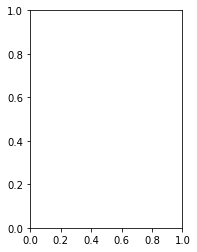

In [103]:
plt.subplot(1,2,1)

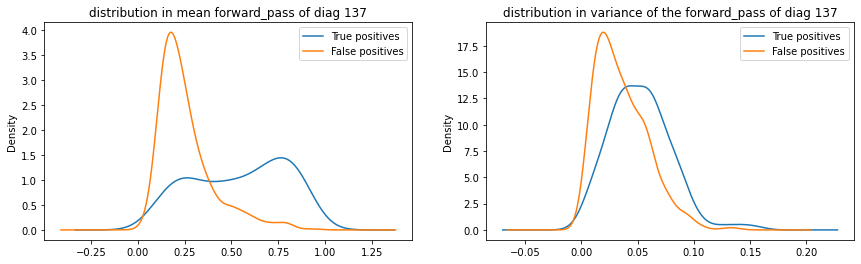

In [118]:
#parameter
diag = 137


diag_col = f'diag_{diag}'
plt.subplot(1,2,1)
tp_means[diag_col].plot.kde(label='True positives');
fp_means[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in mean forward_pass of diag {diag}');
plt.legend();
#plt.show();
plt.subplots_adjust(right=2) 
plt.subplot(1,2,2)
tp_variances[diag_col].plot.kde(label='True positives');
fp_variances[diag_col].plot.kde(label='False positives');
plt.title(f'distribution in variance of the forward_pass of diag {diag}');
plt.legend();

# Model whether a prediction will be FP or TP

# Dumb classifier

since some diagnostics won't have enough data to train a model on, we will use 'dumb' classifiers to keep the pipeline consistent. These classifiers will always predict the positive class

In [248]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class DumbClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self):
        pass
    def fit(self, X, y):
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        # Store the classes seen during fit
        #self.classes_ = unique_labels(y)
        #self.X_ = X
        #self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):
         # Check if fit has been called
        #check_is_fitted(self)
        
        # Input validation
        #X = check_array(X)
        y = np.zeros(shape=(X.shape[0],),dtype=int)
        return y

# test this out
from sklearn.pipeline import make_pipeline

X = np.ones(shape=(5,5))
y = np.random.randint(0,2,size=(5,))

pipe = make_pipeline(DumbClassifier())

pipe.fit(X,y)
pipe.predict(X) # Expecting all ones

Pipeline(steps=[('dumbclassifier', DumbClassifier())])

array([0, 0, 0, 0, 0])

# Build dataset

we shall build the dataset using the validation set (from the original train-val-test split).

We need:
1. obtain predictions on the validation set
2. gather all TP and FP examples
3. construct N tabular datasets (one for each diagnostic)
4. split each into train-test
5. train and test classifier
    1. metric should be precision, recall and f1

In [249]:
outs, golden = outs2df_mc(model,val_dataloader,dataset,return_golden=True)

In [250]:
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])

k = 30
topk_outputs = stats_outs.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_outs.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_outs.index)
#topk_predictions.head(1)

TP = (topk_predictions == 1) & (golden == 1)
FP = (topk_predictions == 1) & (golden == 0)

variances = stats_outs.loc[idx[:,:],idx[:,'var']]
variances.columns = variances.columns.get_level_values(0)
#variances.head(1)

means = stats_outs.loc[idx[:,:],idx[:,'mean']]
means.columns = means.columns.get_level_values(0)
means.head(1)

tp_variances = variances.where(TP,np.nan)
fp_variances = variances.where(FP,np.nan)

tp_means = means.where(TP,np.nan)
fp_means = means.where(FP,np.nan)

,,diag_0,diag_1,diag_2,diag_3,diag_4,diag_5,diag_6,diag_7,diag_8,diag_9,...,diag_262,diag_263,diag_264,diag_265,diag_266,diag_267,diag_268,diag_269,diag_270,diag_271
pat_id,adm_index,,,,,,,,,,,,,,,,,,,,,
21,1,0.041914,0.31054,0.161384,0.175384,0.043563,0.091752,0.013618,0.008234,0.00364,0.058517,...,0.000841,0.013482,0.000462,0.013974,0.121939,0.132394,0.007967,0.008295,0.004178,0.04441


In [251]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,precision_score,f1_score

In [253]:
# need two conditions to decide wether to use the dumb classifier or not
# 1) threhsold on the number of examples
# 2) and there must be examples of both classes

df_metrics = pd.DataFrame(columns=['diag','precision','recall','f1','clf','type'])

clf_party = {}
threshold = 20
for diag in outs.columns:
    
    n_TP = (TP[diag] == True).sum()
    n_FP = (FP[diag] == True).sum()
    
    total_n = n_TP + n_FP
    
    if total_n < threshold or n_TP < 5 or n_FP < 5:
        #use dumb classifier
        clf = DumbClassifier()
        df_metrics = df_metrics.append({'diag':diag,'precision':np.nan,'recall':np.nan,'f1':np.nan,'clf':clf,'type':'dumb'},ignore_index=True)
    else:
        #use logistic regression
        
        ## create dataset
        mean_tp = means[diag][TP[diag]].to_frame('mean')
        mean_fp = means[diag][FP[diag]].to_frame('mean')
        
        var_tp = variances[diag][TP[diag]].to_frame('var')
        var_fp = variances[diag][FP[diag]].to_frame('var')
        
        df_tp = pd.concat([mean_tp,var_tp],axis=1).assign(label=0).reset_index(drop=True)
        df_fp = pd.concat([mean_fp,var_fp],axis=1).assign(label=1).reset_index(drop=True)
        
        df = pd.concat([df_tp,df_fp],ignore_index=True).sample(frac=1.0)
        
        ## split into train-test
        
        X_train,X_test,y_train,y_test = train_test_split(df[['mean','var']],df['label'],stratify=df['label'])
        
        ## train
        clf = LogisticRegression(class_weight="balanced");
        clf.fit(X_train,y_train);
        
        ## evaluate
        preds = clf.predict(X_test);
        
        precision = precision_score(y_test,preds)
        recall = recall_score(y_test,preds)
        f1 = f1_score(y_test,preds)
        
        df_metrics = df_metrics.append({'diag':diag,'precision':precision,'recall':recall,'f1':f1,'clf':clf,'type':'model'},ignore_index=True)
    
    clf_party[diag] = clf
    

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

LogisticRegression(class_weight='balanced')

In [254]:
df_metrics.f1.describe()

count    132.000000
mean       0.787429
std        0.123074
min        0.166667
25%        0.727273
50%        0.799202
75%        0.857143
max        1.000000
Name: f1, dtype: float64

In [255]:
df_metrics = df_metrics.set_index('diag')
df_metrics.head(2)

,precision,recall,f1,clf,type
diag,,,,,
diag_0,NaN,NaN,NaN,DumbClassifier(),dumb
diag_1,0.862944,0.696721,0.770975,LogisticRegression(class_weight='balanced'),model


## Classifiers are trained. Now we need to apply them

In [285]:
outs, golden = outs2df_mc(model,test_dataloader,dataset,return_golden=True)

In [286]:
stats_outs = outs.groupby(['pat_id','adm_index']).agg(['mean','var'])
stats_outs.head(3)

diag_0              diag_1              diag_2            \
                      mean       var      mean       var      mean       var   
pat_id adm_index                                                               
111    1          0.007347  0.000059  0.095935  0.001939  0.054314  0.000623   
145    1          0.002079  0.000003  0.466393  0.018681  0.164556  0.004913   
199    1          0.011444  0.000142  0.086913  0.002136  0.057785  0.000624   

                    diag_3              diag_4            ...  diag_267  \
                      mean       var      mean       var  ...      mean   
pat_id adm_index                                          ...             
111    1          0.091747  0.003034  0.002875  0.000017  ...  0.077534   
145    1          0.097382  0.001239  0.001913  0.000012  ...  0.112730   
199    1          0.049028  0.000401  0.005940  0.000190  ...  0.081583   

                            diag_268            diag_269                \
                       var      mean       var      mean           var   
pat_id adm_index                                                         
111    1          0.002375  0.005107  0.000012  0.000833  4.116630e-07   
145    1          0.002911  0.010506  0.000069  0.001139  3.693598e-07   
199    1          0.000585  0.005190  0.000016  0.003351  7.213809e-06   

                  diag_270            diag_271            
                      mean       var      mean       var  
pat_id adm_index                                          
111    1          0.010200  0.000046  0.028682  0.000205  
145    1          0.012641  0.000034  0.039479  0.000316  
199    1          0.007857  0.000015  0.019741  0.000171  

[3 rows x 544 columns]

In [287]:
k = 30
topk_outputs = stats_outs.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
original_class_columns = stats_outs.columns.get_level_values(0).unique()
missing_cols = [col for col in original_class_columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[original_class_columns]

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=original_class_columns,index=stats_outs.index)

In [288]:
def abstain(row,df_metrics,stats_outs):
    new_row = row.copy()
    admission_forward_stats = stats_outs.loc[row.name,:]
    for index,elem in row.iteritems():
        if elem == 1:
            datapoint = admission_forward_stats[index].to_numpy()
            clf = df_metrics.loc[index,'clf']
            pred = clf.predict(datapoint.reshape((-1,2)))
            
            if pred == 1: #abstain
                new_row[index] = 0
    return new_row

In [289]:
top_k_predictions_abstained = topk_predictions.apply(lambda row: abstain(row,df_metrics,stats_outs),axis=1)

In [290]:
from rnn_utils import compute_metrics

In [304]:
metrics_normal = compute_metrics(topk_outputs_all_cols.fillna(0),topk_predictions,golden,['precision@30','recall@30','f1@30'])

In [301]:
topk_outputs_all_cols_after_abstention = topk_outputs_all_cols.fillna(0).mask(top_k_predictions_abstained == 0,0)

In [303]:
metrics_w_abstention = compute_metrics(topk_outputs_all_cols_after_abstention,top_k_predictions_abstained,golden,['precision@30','recall@30','f1@30'])

In [305]:
metrics_normal.name = 'initial top 30'
metrics_w_abstention.name = 'top 30 + abstention through MC dropout'

In [310]:
pd.concat([metrics_normal,metrics_w_abstention],axis=1).iloc[3:]

,initial top 30,top 30 + abstention through MC dropout
metrics,,
precision@30_adm,0.275293,0.472482
recall@30_adm,0.700669,0.449377
f1@30_adm,0.378810,0.432183


-----

In [119]:
from sklearn.linear_model import LogisticRegression

In [120]:
clf = LogisticRegression()

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

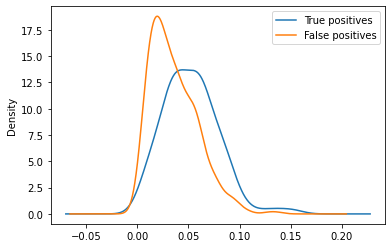

In [92]:
tp_variances.diag_137.plot.kde(label='True positives')
fp_variances.diag_137.plot.kde(label='False positives')
plt.legend()

In [86]:
golden.sum(axis=0).sort_values().where(lambda x: x > 100).dropna()

diag_53     104.0
diag_51     111.0
diag_149    111.0
diag_239    112.0
diag_122    119.0
diag_5      129.0
diag_101    138.0
diag_246    140.0
diag_120    142.0
diag_221    143.0
diag_116    146.0
diag_115    147.0
diag_92     155.0
diag_87     156.0
diag_90     167.0
diag_58     168.0
diag_70     171.0
diag_121    175.0
diag_226    176.0
diag_267    178.0
diag_137    183.0
diag_176    188.0
diag_188    188.0
diag_139    200.0
diag_117    207.0
diag_84     208.0
diag_249    218.0
diag_105    228.0
diag_47     237.0
diag_56     237.0
diag_60     242.0
diag_104    262.0
diag_2      268.0
diag_266    285.0
diag_49     287.0
diag_243    288.0
diag_214    316.0
diag_83     320.0
diag_141    333.0
diag_145    335.0
diag_125    339.0
diag_109    341.0
diag_114    346.0
diag_82     363.0
diag_48     377.0
diag_1      382.0
diag_233    421.0
diag_86     423.0
diag_144    467.0
diag_215    471.0
diag_52     525.0
diag_235    526.0
diag_143    531.0
diag_118    532.0
diag_57     598.0
diag_88   

In [ ]:
k = 30
topk_outputs = res.apply(lambda row: row.loc[idx[:,'mean']].nlargest(k),axis=1)

# fix missing columns from previous operation
missing_cols = [col for col in model_outputs.columns if col not in topk_outputs.columns]
topk_outputs_all_cols = pd.concat([topk_outputs,pd.DataFrame(columns=missing_cols)])
topk_outputs_all_cols = topk_outputs_all_cols[model_outputs.columns]

## sometimes k > (#logits>0) so we will turn all 0 logits into nan so that the following lines don't convert them to predictions
topk_outputs_all_cols = topk_outputs_all_cols.mask(topk_outputs_all_cols == 0,np.nan)
# done, continuing...

topk_predictions = np.where(topk_outputs_all_cols.isna(),0,1)
topk_predictions = pd.DataFrame(data=topk_predictions,columns=model_predictions.columns,index=model_predictions.index)

In [20]:
def train_multiple_epochs(**kwargs):
    n_epochs = kwargs.get('n_epochs',15)
    
    
    model = VariationalRNN(kwargs.get('input_size'),
                           kwargs.get('hidden_size'),
                           kwargs.get('n_labels'),
                           kwargs.get('num_layers'),
                           kwargs.get('rnn_type'),
                           kwargs.get('dropoutii'),
                           kwargs.get('dropoutww'),
                           kwargs.get('dropoutoo'))
    
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(n_epochs):
        train_one_epoch(model,train_dataloader,epoch,criterion,opt)
    
    res = eval_model(model,val_dataloader,dataset,criterion,'all','eval',False,'last adm',30)
    return res['last adm']['recall30']['mean']
func = lambda dropoutii,dropoutww,dropoutoo: train_multiple_epochs(n_epochs=10,
                                                                input_size=input_size,
                                                                hidden_size=hidden_size,
                                                                n_labels=n_labels,
                                                                num_layers=num_layers,
                                                                rnn_type=model_type,
                                                                dropoutii=dropoutii,
                                                                dropoutww=dropoutww,
                                                                dropoutoo=dropoutoo)

In [13]:
# bayesian optimization

## bounds of parameter search
pbounds = {'dropoutii': (0.1,0.8), 
           'dropoutww': (0.1,0.8),
           'dropoutoo': (0.1,0.8)
          }

## parameter search
optimizer = BayesianOptimization(
    f=func,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(init_points=5,n_iter=15)

|   iter    |  target   | dropoutii | dropoutoo | dropoutww |
-------------------------------------------------------------
|  1        |  0.6002   |  0.3919   |  0.6042   |  0.1001   |
|  2        |  0.5985   |  0.3116   |  0.2027   |  0.1646   |
|  3        |  0.6059   |  0.2304   |  0.3419   |  0.3777   |
|  4        |  0.5755   |  0.4772   |  0.3934   |  0.5797   |
|  5        |  0.5895   |  0.2431   |  0.7147   |  0.1192   |
|  6        |  0.5383   |  0.3631   |  0.6529   |  0.6421   |
|  7        |  0.6168   |  0.1      |  0.1      |  0.4499   |
|  8        |  0.5568   |  0.1      |  0.1      |  0.8      |
|  9        |  0.5687   |  0.2593   |  0.2089   |  0.7631   |
|  10       |  0.5874   |  0.6084   |  0.61     |  0.2363   |
|  11       |  0.6287   |  0.1      |  0.1      |  0.242    |
|  12       |  0.5682   |  0.7688   |  0.5648   |  0.4295   |


KeyboardInterrupt: 

In [16]:
#best_params_1st_run = optimizer.max
#best_params_1st_run

best_params = optimizer.max
best_params

{'target': 0.6287178853774116,
 'params': {'dropoutii': 0.1,
  'dropoutoo': 0.1,
  'dropoutww': 0.2419500529180941}}